In [1]:
import sys
import os
from pathlib import Path
from collections import defaultdict
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch


os.chdir('..')

from utils.model_factory import load_models
from utils.meta_util import load_meta_infos, collect_by
from utils.data_holder import DataHolder
from utils.tensor_holders import TensorHolder
from utils.np_util import step_with_end
from utils.plot_util import plot, legend
from tasks.train_polynomial import TrainPolynomial
from distributions.mc_estimators.measure_valued import MVEstimator
from distributions.mc_estimators.pathwise import PathwiseEstimator
from distributions.mc_estimators.score_function import SFEstimator

_ = torch.empty(0)

plot_dir = Path('results')

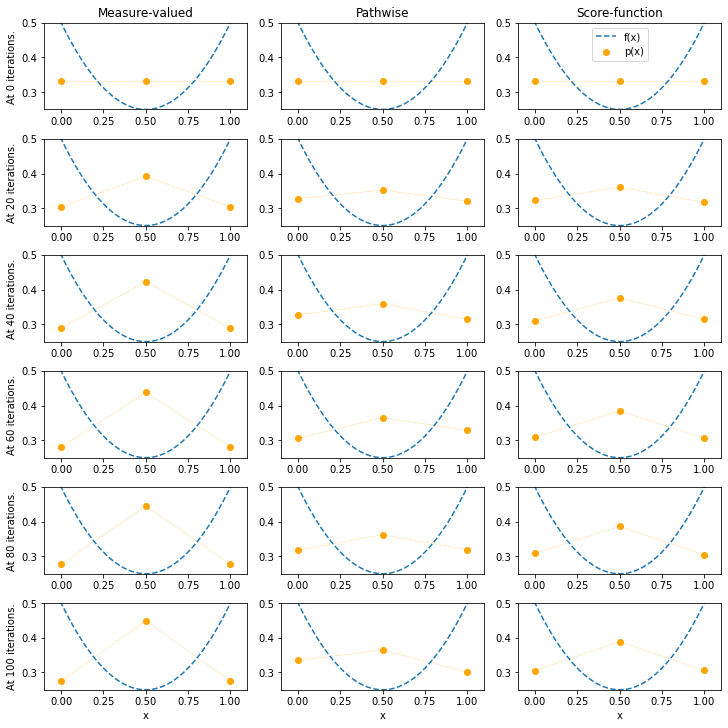

In [2]:
ylim = (0.25, 0.5)

loss_space = torch.linspace(-0.1, 1.1, 200)
loss_fn = TrainPolynomial.quadratic(loss_space) + ylim[0]

cat_3_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'cat_3')) if p.parent.name == str(9074185)]
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_3_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 20} iterations.") 

for path, model in cat_3_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations) // 20
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    x = x / 2
    
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_xlim(loss_space.min(), loss_space.max())
    axis.set_ylim(*ylim)

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_parabola_3.pdf')
plt.show()

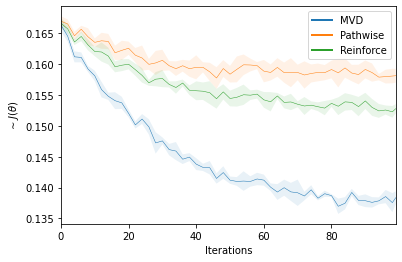

In [3]:
cat_3_metas = load_meta_infos(Path('results', 'polynomial', 'cat_3'))

test_losses = defaultdict(list)
for k, v in collect_by(cat_3_metas, 'mc_estimator').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 2
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), meta['mc_estimator'], meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylabel('$\\sim J(\\theta)$')
plt.xlabel('Iterations')
plt.savefig(plot_dir / f'cat_3_losses.pdf')
plt.show()

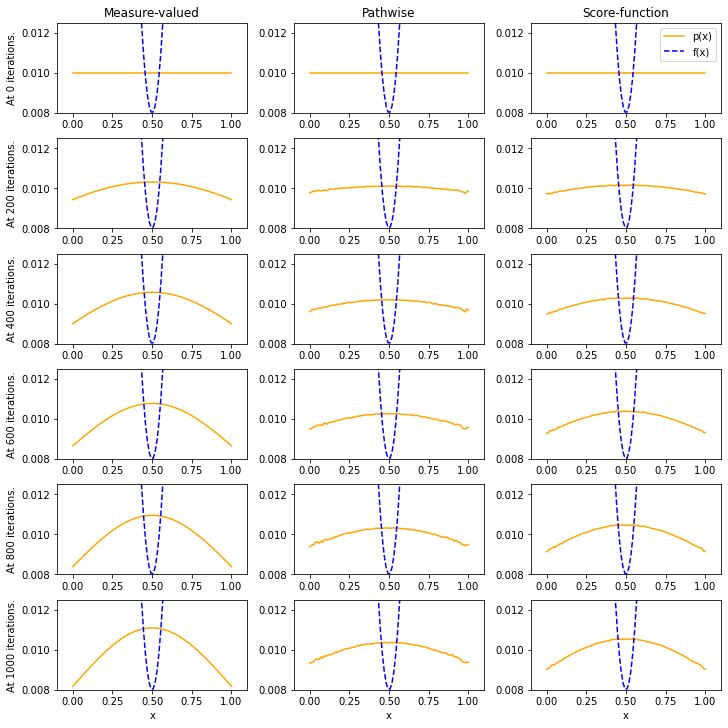

In [4]:
ylim = (0.008, 0.0125)

loss_space = torch.linspace(-0.1, 1.1, 100)
loss_fn = TrainPolynomial.quadratic(loss_space) + ylim[0]

cat_100_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'cat_100')) if p.parent.name == str(9074185)]
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_100_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 200} iterations.") 

for path, model in cat_100_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    if path.parent.name != '9074185':
        continue
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    x = x / 99
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 200, col]
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(*ylim)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_parabola_100.pdf')
plt.show()

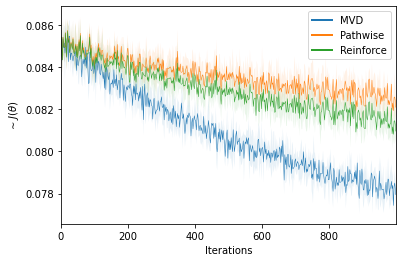

In [5]:
cat_100_metas = load_meta_infos(Path('results', 'polynomial', 'cat_100'))

test_losses = defaultdict(list)
for k, v in collect_by(cat_100_metas, 'mc_estimator').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 2
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), meta['mc_estimator'], meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylabel('$\\sim J(\\theta)$')
plt.xlabel('Iterations')
plt.savefig(plot_dir / f'cat_100_losses.pdf')
plt.show()

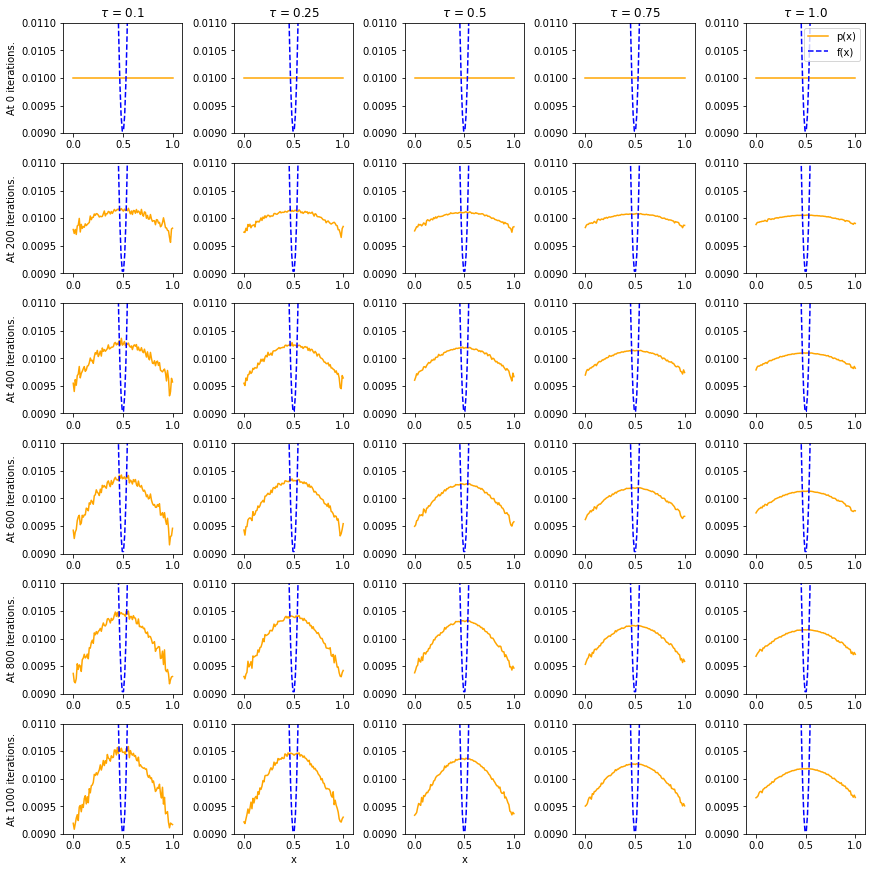

In [6]:
ylim = (0.009, 0.011)

loss_space = torch.linspace(-0.1, 1.1, 100)
loss_fn = TrainPolynomial.quadratic(loss_space) + ylim[0]

cat_gumbel_temperatures_100_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'cat_gumbel_temperatures_100')) if p.parent.name == str(9074185)]
temperatures = sorted({p.parent.parent.name for p, m in cat_gumbel_temperatures_100_models})
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
axs = fig.subplots(len(cat_gumbel_temperatures_100_models) // len(temperatures), len(temperatures))

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 200} iterations.") 

for path, model in cat_gumbel_temperatures_100_models:
    temperature = path.parent.parent.name
    name, iterations = path.stem.split('_')
    row = int(iterations) // 200
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    x = x / 99
    
    col = temperatures.index(temperature)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\tau$ = {temperature}")
    
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(*ylim)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'gumbel_softmax_temperatures.pdf')
plt.show()

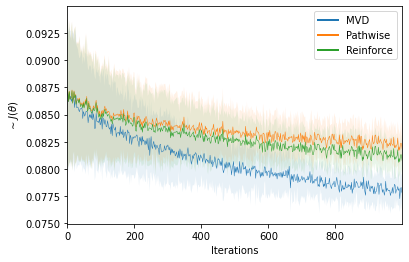

In [7]:
cat_100_rinit_metas = load_meta_infos(Path('results', 'polynomial', 'cat_100_random_init'))

test_losses = defaultdict(list)
for k, v in collect_by(cat_100_rinit_metas, 'mc_estimator').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 2
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), meta['mc_estimator'], meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylabel('$\\sim J(\\theta)$')
plt.xlabel('Iterations')
plt.savefig(plot_dir / f'cat_100_random_init_losses.pdf')
plt.show()

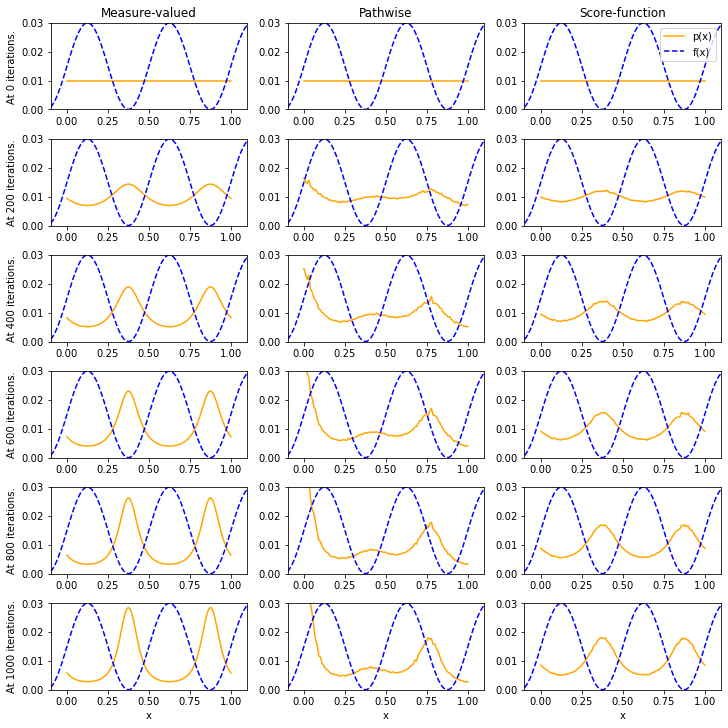

In [8]:
ylim = (0., 0.03)

loss_space = torch.linspace(-0.1, 1.1, 100)
loss_fn = (TrainPolynomial.sinusoid(loss_space) + 1) * 0.5 * ylim[1] + ylim[0]

cat_100_sinusoid_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'cat_100_sinusoid')) if p.parent.name == str(9074185)]
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(cat_100_models) // 3, 3)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(PathwiseEstimator.name().capitalize())
axs[0,2].set_title(SFEstimator.name().capitalize())

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 200} iterations.") 

for path, model in cat_100_sinusoid_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations)
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    x = x / 99
    
    if name == MVEstimator.name():
        col = 0
    elif name == PathwiseEstimator.name():
        col = 1
    elif name == SFEstimator.name():
        col = 2
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations // 200, col]
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(*ylim)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'categoricals_sinusoid_100.pdf')
plt.show()

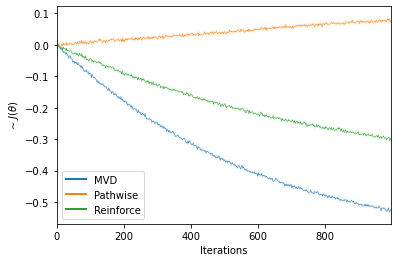

In [9]:
cat_100_sinusoid_metas = load_meta_infos(Path('results', 'polynomial', 'cat_100_sinusoid'))

test_losses = defaultdict(list)
for k, v in collect_by(cat_100_sinusoid_metas, 'mc_estimator').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 2
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), meta['mc_estimator'], meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylabel('$\\sim J(\\theta)$')
plt.xlabel('Iterations')
plt.savefig(plot_dir / f'cat_100_sinusoid_losses.pdf')
plt.show()

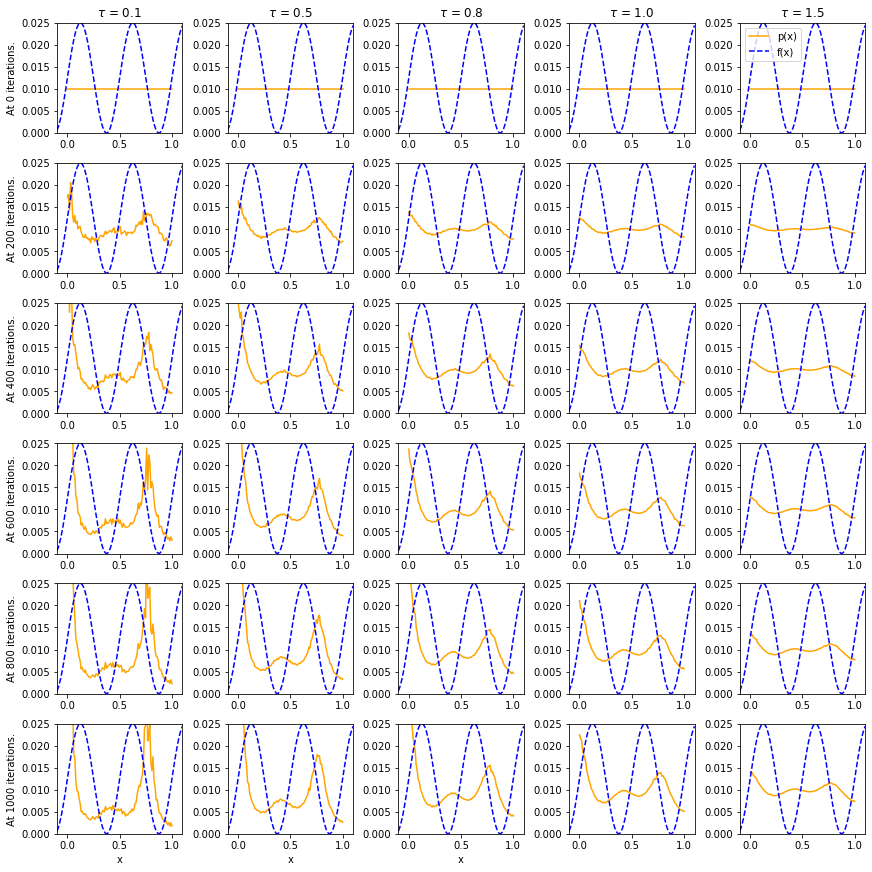

In [10]:
ylim = (0., 0.025)

loss_space = torch.linspace(-0.1, 1.1, 100)
loss_fn = (TrainPolynomial.sinusoid(loss_space) + 1) * 0.5 * ylim[1] + ylim[0]

cat_gumbel_temperatures_100_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'cat_gumbel_temperatures_100_sinusoid')) if p.parent.name == str(9074185)]
temperatures = sorted({p.parent.parent.name for p, m in cat_gumbel_temperatures_100_models})
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
axs = fig.subplots(len(cat_gumbel_temperatures_100_models) // len(temperatures), len(temperatures))

for i in range(3):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {i * 200} iterations.") 

for path, model in cat_gumbel_temperatures_100_models:
    temperature = path.parent.parent.name
    name, iterations = path.stem.split('_')
    row = int(iterations) // 200
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf()
    x = x / 99
    
    col = temperatures.index(temperature)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\tau$ = {temperature}")
    
    axis.plot(x, pdf, label="p(x)", color='orange')
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed', color='blue')
    axis.set_ylim(*ylim)
    axis.set_xlim(loss_space.min(), loss_space.max())

axs[0,-1].legend()
plt.savefig(plot_dir / 'gumbel_softmax_temperatures_sinusoid.pdf')
plt.show()

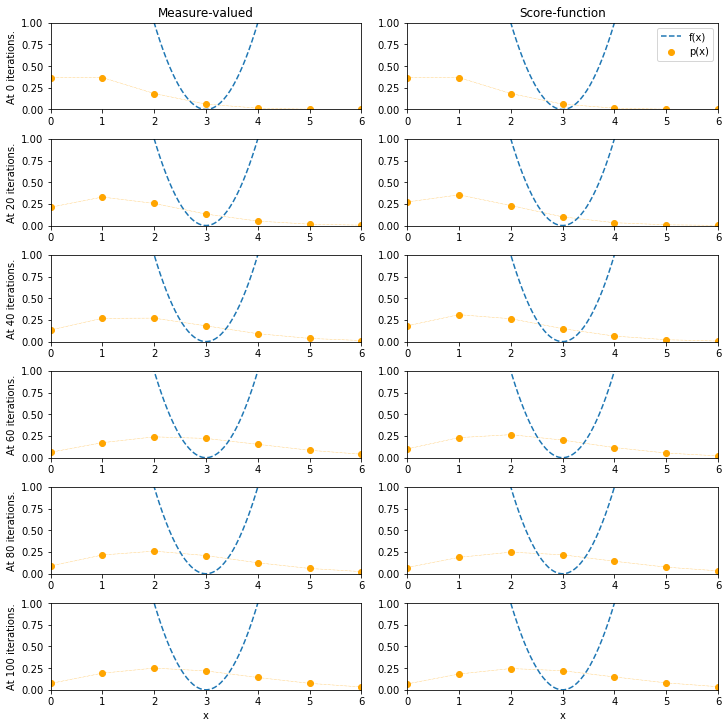

In [11]:
ylim = (0., 1.)

loss_space = torch.linspace(0, 6, 200)
loss_fn = TrainPolynomial.quadratic_shifted(loss_space) + ylim[0]

poisson_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'poisson')) if p.parent.name == str(9074185)]
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
axs = fig.subplots(len(poisson_models) // 2, 2)

axs[0,0].set_title(MVEstimator.name().capitalize())
axs[0,1].set_title(SFEstimator.name().capitalize())

for i in range(2):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {20 * i} iterations.") 

for path, model in poisson_models:
    name, iterations = path.stem.split('_')
    iterations = int(iterations) // 20
    
    if name == MVEstimator.name():
        col = 0
    elif name == SFEstimator.name():
        col = 1
    else:
        raise ValueError(f"Unknown name {name}.")
        
    axis = axs[iterations, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf(end=20)
    
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_xlim(loss_space.min(), loss_space.max())
    axis.set_ylim(*ylim)

axs[0,-1].legend()
plt.savefig(plot_dir / 'poisson_parabola.pdf')
plt.show()

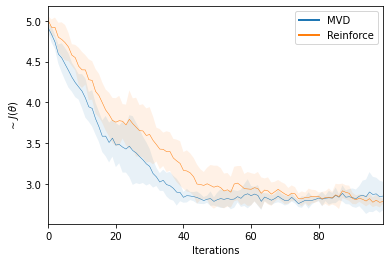

In [12]:
poisson_metas = load_meta_infos(Path('results', 'polynomial', 'poisson'))

test_losses = defaultdict(list)
for k, v in collect_by(poisson_metas, 'mc_estimator').items():
    for meta in v:
        test_losses[k].append((meta, TensorHolder.load(meta['results_dir'], 'test_loss')))
test_losses.default_factory = None

step_size = 1
max_len = 0
for run in test_losses.values():
    meta, _ = run[0]
    losses = []
    for meta, loss in run:
        losses.append(loss.data.numpy().flatten())
    indices, losses = step_with_end(np.array(losses), step_size)
    plot(losses.mean(axis=0), losses.std(axis=0), meta['mc_estimator'], meta, xspace=indices)
    max_len = max(max_len, indices[-1])

legend()
plt.xlim(0, max_len)
plt.ylabel('$\\sim J(\\theta)$')
plt.xlabel('Iterations')
plt.savefig(plot_dir / f'poisson_losses.pdf')
plt.show()

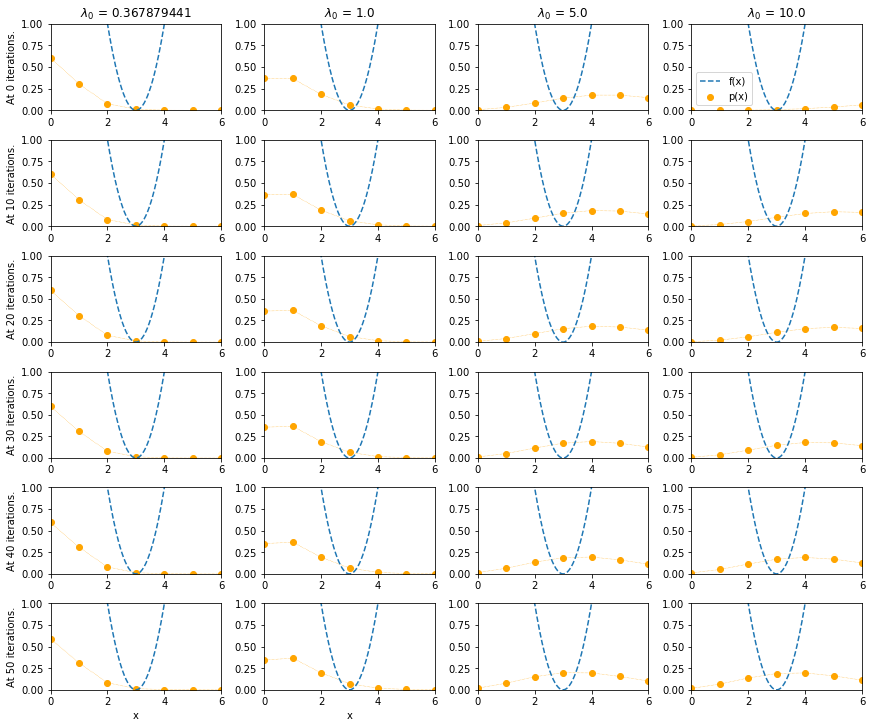

In [13]:
ylim = (0., 1.)

loss_space = torch.linspace(0, 6, 200)
loss_fn = TrainPolynomial.quadratic_shifted(loss_space) + ylim[0]

poisson_sf_init_params_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'poisson_sf_init_params')) if p.parent.name == str(9074185)]
init_rates = sorted({float(p.parent.parent.name) for p, m in poisson_sf_init_params_models})
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
axs = fig.subplots(len(poisson_sf_init_params_models) // len(init_rates), len(init_rates))

for i in range(2):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {10 * i} iterations.") 

for path, model in poisson_sf_init_params_models:
    init_rate = float(path.parent.parent.name)
    name, iterations = path.stem.split('_')
    row = int(iterations) // 10
    
    col = init_rates.index(init_rate)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\lambda_0$ = {init_rate}")
        
    axis = axs[row, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf(end=20)
    
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_xlim(loss_space.min(), loss_space.max())
    axis.set_ylim(*ylim)

axs[0,-1].legend()
plt.savefig(plot_dir / 'poisson_sf_parabola.pdf')
plt.show()

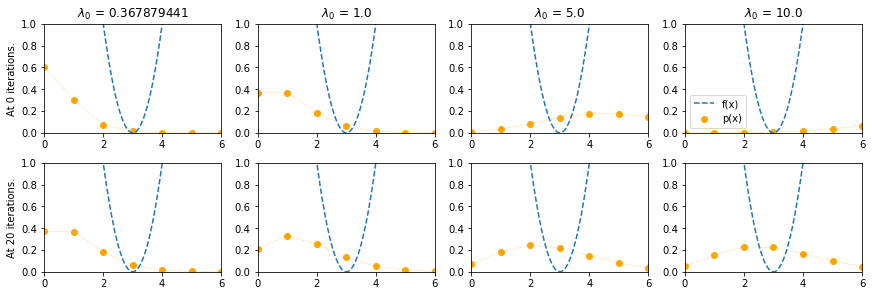

In [14]:
ylim = (0., 1.)

loss_space = torch.linspace(0, 6, 200)
loss_fn = TrainPolynomial.quadratic_shifted(loss_space) + ylim[0]

poisson_mvd_init_params_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'poisson_mvd_init_params')) if p.parent.name == str(9074185)]
init_rates = sorted({float(p.parent.parent.name) for p, m in poisson_mvd_init_params_models})
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
axs = fig.subplots(2, len(init_rates))

axs[0, 0].set_ylabel(f"At 0 iterations.")
axs[1, 0].set_ylabel(f"At 20 iterations.")

for path, model in poisson_mvd_init_params_models:
    init_rate = float(path.parent.parent.name)
    name, iterations = path.stem.split('_')
    row = int(iterations) // 10
    
    if int(iterations) == 0:
        row = 0
    elif int(iterations) == 20:
        row = 1
    else:
        continue
    
    col = init_rates.index(init_rate)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\lambda_0$ = {init_rate}")
        
    axis = axs[row, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf(end=20)
    
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_xlim(loss_space.min(), loss_space.max())
    axis.set_ylim(*ylim)

axs[0,-1].legend()
plt.savefig(plot_dir / 'poisson_mvd_parabola.pdf')
plt.show()

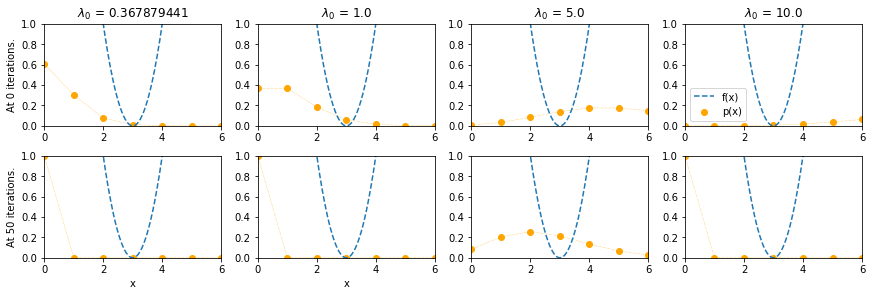

In [15]:
ylim = (0., 1.)

loss_space = torch.linspace(0, 6, 200)
loss_fn = TrainPolynomial.quadratic_shifted(loss_space) + ylim[0]

poisson_sf_lr_problem_models = [(p, m) for p, m in load_models(Path('results', 'polynomial', 'poisson_sf_lr_problem')) if p.parent.name == str(9074185)]
init_rates = sorted({float(p.parent.parent.name) for p, m in poisson_sf_lr_problem_models})
fig = plt.figure(figsize=(12, 4), constrained_layout=True)
axs = fig.subplots(len(poisson_sf_lr_problem_models) // len(init_rates), len(init_rates))

for i in range(2):
    axs[-1, i].set_xlabel("x")
for i in range(len(axs)):
    axs[i, 0].set_ylabel(f"At {50 * i} iterations.") 

for path, model in poisson_sf_lr_problem_models:
    init_rate = float(path.parent.parent.name)
    name, iterations = path.stem.split('_')
    row = int(iterations) // 50
    
    col = init_rates.index(init_rate)
    axis = axs[row, col]
    if row == 0:
        axis.set_title(f"$\\lambda_0$ = {init_rate}")
        
    axis = axs[row, col]
    
    distribution = model.cpu().encode(_)
    x, pdf = distribution.pdf(end=20)
    
    axis.scatter(x, pdf, label="p(x)", color='orange')
    axis.plot(x, pdf, color='orange', linestyle='dotted', linewidth=.5)
    axis.plot(loss_space, loss_fn, label="f(x)", linestyle='dashed')
    
    axis.set_xlim(loss_space.min(), loss_space.max())
    axis.set_ylim(*ylim)

axs[0,-1].legend()
plt.savefig(plot_dir / 'poisson_sf_lr_problem.pdf')
plt.show()